# Trial on Block Matching (using Github repo)

Shapes: (288, 384) (288, 384)


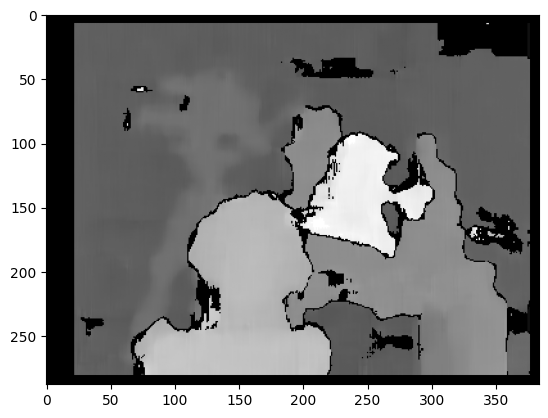

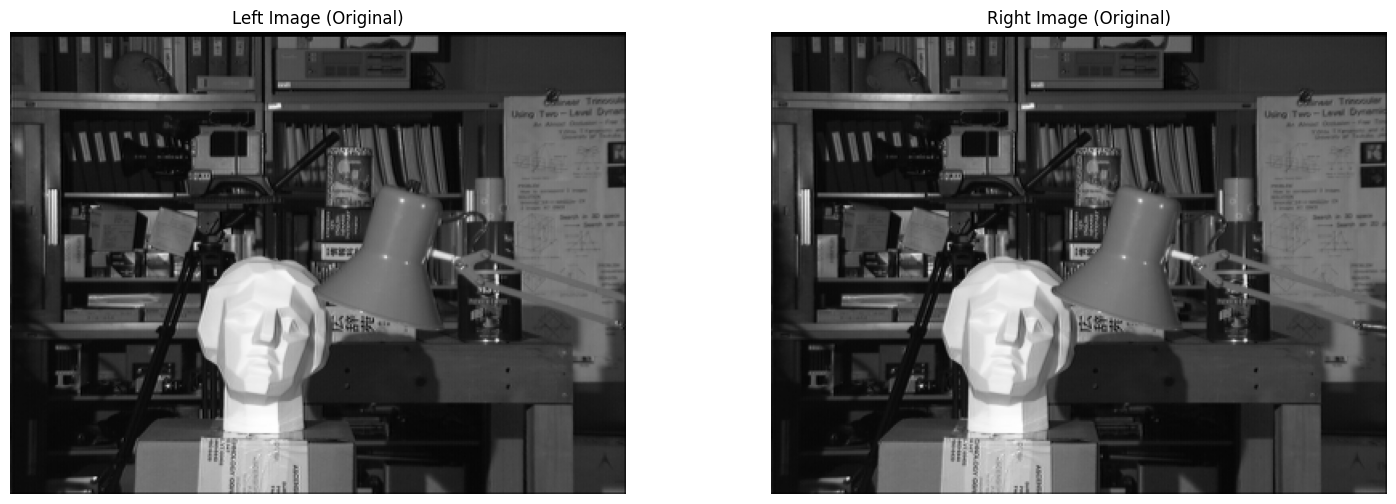

In [151]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Load images
imgL = cv.imread('DisparityMapfromStereoPair-master/tsukuba_l.png', cv.IMREAD_GRAYSCALE)
imgR = cv.imread('DisparityMapfromStereoPair-master/tsukuba_r.png', cv.IMREAD_GRAYSCALE)

# Check loading
if imgL is None or imgR is None:
    raise ValueError("One or both images not loaded. Check file paths!")

# Check shape
print("Shapes:", imgL.shape, imgR.shape)
if imgL.shape != imgR.shape:
    imgR = cv.resize(imgR, (imgL.shape[1], imgL.shape[0]))

# Stereo BM
stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)
# numDisparities : Must be > 0 and multiple of 16 (OpenCV requirement).
# blockSize : Must be odd, between 5 and 255, and not larger than image width/height.
disparity = stereo.compute(imgL, imgR)
# result is typically CV_16S (signed 16-bit) and disparities are scaled by 16 (i.e. fixed-point with 4 fractional bits).
# So the real disparity in pixels = disparity.astype(np.float32) / 16.0.

# Normalize for display
disp_vis = cv.normalize(disparity, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

plt.imshow(disp_vis, cmap='gray')
plt.show()


plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')
plt.title("Left Image (Original)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')
plt.title("Right Image (Original)")
plt.axis('off')

plt.show()

In [152]:
# # Block matching Object Modification 

# window_size = 5
# min_disp = 0
# num_disp = 16*6
# stereo = cv.StereoSGBM_create(
#     minDisparity=min_disp,
#     numDisparities=num_disp,
#     blockSize=window_size,
#     P1=8*3*window_size**2,
#     P2=32*3*window_size**2,
#     disp12MaxDiff=1,
#     uniquenessRatio=10,
#     speckleWindowSize=100,
#     speckleRange=32
# )

C:\Users\ABHIGYAN ROY\AppData\Local\Temp\ipykernel_36032\2846041476.py:11: RuntimeWarning: invalid value encountered in cast
  disp_vis = np.uint8(disp_vis)


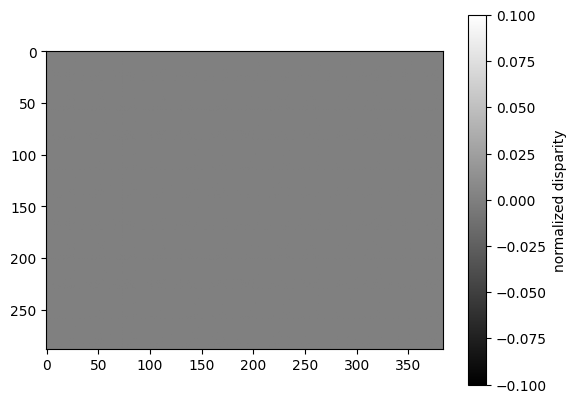

In [153]:
# Unormalised disparity 

disp16 = stereo.compute(imgL, imgR)           # CV_16S, scaled by 16
disp = disp16.astype(np.float32) / 16.0       # real disparity in pixels (float32)

# mask invalid (non-positive) disparities
disp[disp <= 0] = np.nan

# normalized image for display (0..255)
disp_vis = cv.normalize(disp, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
disp_vis = np.uint8(disp_vis)

plt.imshow(disp_vis, cmap='gray')
plt.colorbar(label='normalized disparity')
plt.show()


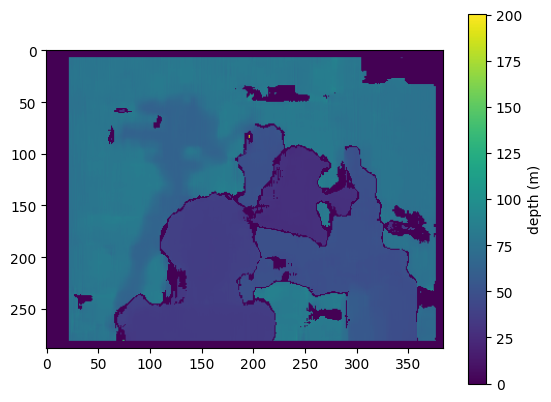

In [154]:
# Depth 

f = 718.856   # example focal length in pixels (from calibration)
B = 0.54      # baseline in meters
depth = f * B / (disp + 1e-6)     # avoid division by zero
depth[~np.isfinite(depth)] = 0
plt.imshow(depth, cmap='viridis')
plt.colorbar(label='depth (m)')
plt.show()


# KITTI Datatest

## Block Matching

Image shape: (375, 1242) (375, 1242)


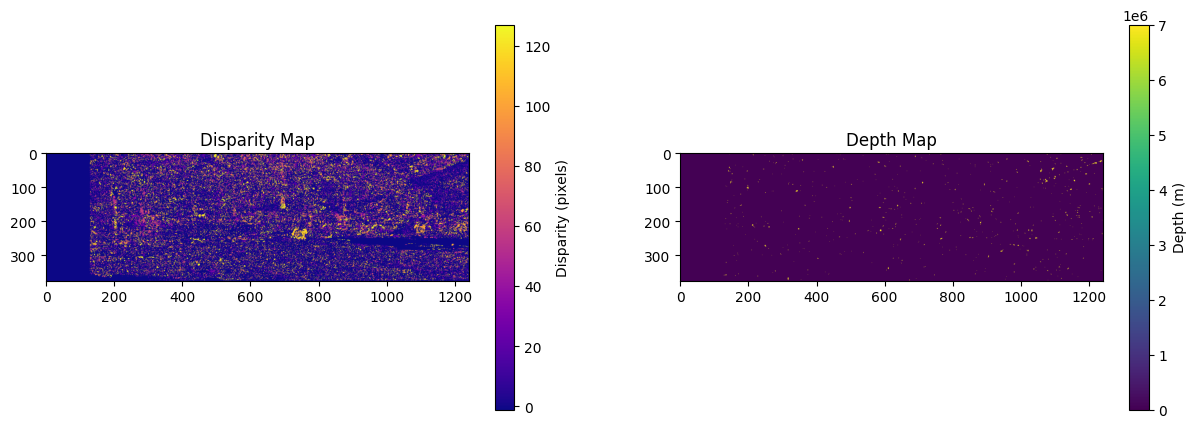

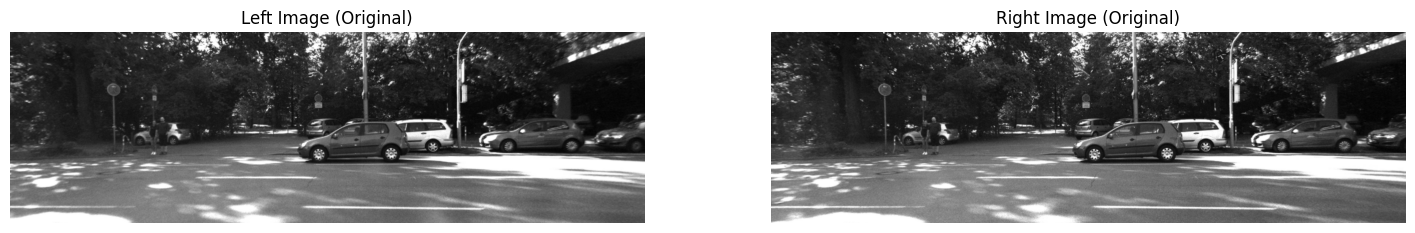

In [155]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# ================================
# 1. Load KITTI stereo image pair
# ================================
# left: 000000_10.png, right: 000000_11.png
left_path = "datasets/data_scene_flow/testing/image_3/000157_10.png"
right_path = "datasets/data_scene_flow/testing/image_2/000157_10.png"

imgL = cv.imread(left_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_path, cv.IMREAD_GRAYSCALE)

if imgL is None or imgR is None:
    raise FileNotFoundError("Images not found. Check your paths!")

print("Image shape:", imgL.shape, imgR.shape)

# =====================================
# 2. Stereo matcher 
# =====================================
window_size = 5  # blockSize : Must be odd, between 5 and 255, and not larger than image width/height.
num_disp = 16*8   # numDisparities : Must be > 0 and multiple of 16 (OpenCV requirement).

stereo = cv.StereoBM.create(numDisparities=num_disp, blockSize= window_size)
# stereo.setTextureThreshold(5)
# stereo.setUniquenessRatio(5)
# stereo.setSpeckleWindowSize(10)
# stereo.setSpeckleRange(2)
# stereo.setPreFilterSize(9)
# stereo.setPreFilterCap(31)

# =====================================
# 3. Compute disparity
# =====================================
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0  # divide by 16 to get real disparities

# =====================================
# 4. Convert disparity -> depth (Z)
# =====================================
# KITTI calibration: 
f = 70.0     # focal length in pixels
B = 0.1     # baseline in meters
depth = f * B / (disp + 1e-6)   # avoid division by zero

# =====================================
# 5. Display results
# =====================================
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(disp, cmap='plasma')
plt.colorbar(label="Disparity (pixels)")
plt.title("Disparity Map")

plt.subplot(1,2,2)
plt.imshow(depth, cmap='viridis')
plt.colorbar(label="Depth (m)")
plt.title("Depth Map")

plt.show()

# =====================================
# 6. Show original left image, disparity, and depth together
# =====================================
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')
plt.title("Left Image (Original)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')
plt.title("Right Image (Original)")
plt.axis('off')

plt.show()



# Semi Global Block Matching

In [156]:
# Cell 1: imports and basic utilities
import os
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Optional

# Ensure inline plotting (if not already enabled)
%matplotlib inline

def show_img(img, title="", cmap="gray", figsize=(10,6), vmin=None, vmax=None):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        # OpenCV uses BGR by default, convert to RGB for plotting
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [157]:
# Cell 2: functions to load KITTI stereo images and parse calibration
def load_kitti_pair(left_path: str, right_path: str):
    """Load left and right KITTI images as grayscale and color versions."""
    left_bgr = cv2.imread(left_path, cv2.IMREAD_COLOR)
    right_bgr = cv2.imread(right_path, cv2.IMREAD_COLOR)
    if left_bgr is None or right_bgr is None:
        raise FileNotFoundError(f"Could not load: {left_path} or {right_path}")
    left_gray = cv2.cvtColor(left_bgr, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_bgr, cv2.COLOR_BGR2GRAY)
    return left_bgr, right_bgr, left_gray, right_gray

def parse_kitti_calib(calib_file_path: str) -> dict:
    """
    Parse a KITTI 'calib.txt' line-based calibration file.
    Returns a dict with camera projection matrices P0..P3 (3x4), and focal length+baseline estimate.
    Works with KITTI raw/2012/2015 style calib files (P0..P3 or P2/P3).
    """
    cam = {}
    with open(calib_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            key, vals = line.split(':', 1)
            vals = np.fromstring(vals, sep=' ')
            if key.startswith('P'):
                cam[key] = vals.reshape(3, 4)
            elif key == 'S_rect_02':  # some formats
                cam[key] = vals
            else:
                # keep raw as fallback
                cam[key] = vals
    # Try to compute focal length and baseline from P2 and P3 (most KITTI sets have these)
    if 'P2' in cam and 'P3' in cam:
        P2 = cam['P2']
        P3 = cam['P3']
        # focal length approx is P2[0,0]
        fx = P2[0, 0]
        # baseline * fx = -P3[0,3] + P2[0,3]  (since P = [f 0 cx Tx]) often P3[0,3] = -fx * Tx_right
        # baseline = (Tx_right - Tx_left) in meters if translation in meters; KITTI P matrices use Tx*fx
        # compute baseline in meters: baseline = (P2[0,3] - P3[0,3]) / fx
        Tx_diff = (P2[0, 3] - P3[0, 3])
        baseline = Tx_diff / fx
        cam['fx'] = fx
        cam['baseline'] = baseline
    else:
        cam['fx'] = None
        cam['baseline'] = None
    return cam


In [158]:
# Cell 3: SGBM parameter setup & factory function
def build_sgbm(min_disparity=0,
               num_disparities=128,
               block_size=5,
               P1=None, P2=None,
               disp12_max_diff=1,
               pre_filter_cap=31,
               uniqueness_ratio=10,
               speckle_window_size=100,
               speckle_range=32,
               mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY):
    """
    Build and return a cv2.StereoSGBM matcher with recommended defaults.
    - min_disparity: smallest disparity (usually 0)
    - num_disparities: must be divisible by 16
    - block_size: SAD window size (odd number, typical 3..11)
    - P1, P2: smoothness penalties; if None, computed from block_size
    - mode: SGBM mode. 3WAY is faster on many CPUs.
    """
    if num_disparities % 16 != 0:
        raise ValueError("num_disparities must be divisible by 16")
    if P1 is None:
        P1 = 8 * 1 * block_size * block_size
    if P2 is None:
        P2 = 32 * 1 * block_size * block_size

    sgbm = cv2.StereoSGBM_create(minDisparity=min_disparity,
                                 numDisparities=num_disparities,
                                 blockSize=block_size,
                                 P1=P1,
                                 P2=P2,
                                 disp12MaxDiff=disp12_max_diff,
                                 preFilterCap=pre_filter_cap,
                                 uniquenessRatio=uniqueness_ratio,
                                 speckleWindowSize=speckle_window_size,
                                 speckleRange=speckle_range,
                                 mode=mode)
    return sgbm

# Example: build a default SGBM
sgbm = build_sgbm(min_disparity=0, num_disparities=128, block_size=5)
sgbm


# min_disp = 0
# stereo = cv.StereoSGBM_create(
#     minDisparity=min_disp,
#     numDisparities=num_disp,
#     blockSize=window_size,
#     P1=8*3*window_size**2,
#     P2=32*3*window_size**2,
#     disp12MaxDiff=1,
#     uniquenessRatio=10,
#     speckleWindowSize=100,
#     speckleRange=32
# )

< cv2.StereoSGBM 000001B4B53CD570>

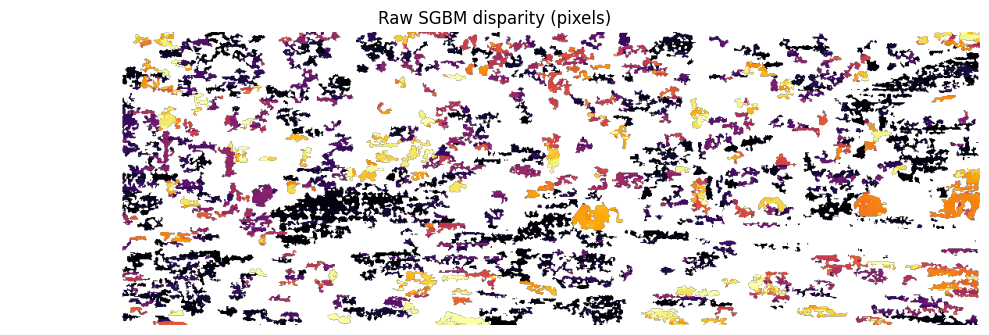

Calibration not found or incomplete — skipping depth conversion.


In [159]:
# Cell 4: run SGBM on a single KITTI pair
left_path = "datasets/data_scene_flow/testing/image_3/000157_10.png"   # update these paths for your dataset
right_path = "datasets/data_scene_flow/testing/image_2/000157_10.png"
calib_path = "datasets/data_scene_flow/data_scene_flow_calib/testing/calib_imu_to_cam/000157.txt"                  # optional

# Load
left_bgr, right_bgr, left_gray, right_gray = load_kitti_pair(left_path, right_path)

# Optionally parse calibration (for depth conversion)
cam = None
if os.path.exists(calib_path):
    cam = parse_kitti_calib(calib_path)
    print("Parsed calib fx, baseline:", cam.get('fx'), cam.get('baseline'))

# Build SGBM (tune num_disparities to image width; e.g. up to width//8, divisible by 16)
height, width = left_gray.shape
# Example: choose num_disparities = nearest multiple of 16 and not too large
num_disp = (width // 8) // 16 * 16
num_disp = max(16, num_disp)  # at least 16
matcher = build_sgbm(min_disparity=0, num_disparities=num_disp, block_size=5)

# Compute disparity (returns fixed-point disparity: disparity*16)
disp16 = matcher.compute(left_gray, right_gray).astype(np.int16)
# Convert to floating disparities in pixels
disp = disp16.astype(np.float32) / 16.0

# Optional: mask invalid disparities (negative or zero)
disp[disp <= 0] = np.nan

# Visualize (use a colormap for clarity)
vmin, vmax = np.nanpercentile(disp, 2), np.nanpercentile(disp, 98)
show_img(disp, title="Raw SGBM disparity (pixels)", cmap='inferno', vmin=vmin, vmax=vmax)

# If calibration is available, compute depth: depth = fx * baseline / disparity
if cam and cam.get('fx') and cam.get('baseline'):
    fx = cam['fx']
    baseline = cam['baseline']
    depth = fx * baseline / disp  # meters (NaN where disp is NaN)
    # Clip extreme depths for visualization
    depth_vis = depth.copy()
    depth_vis[np.isinf(depth_vis)] = np.nan
    d_vmin, d_vmax = np.nanpercentile(depth_vis, 2), np.nanpercentile(depth_vis, 98)
    show_img(depth_vis, title="Depth (meters) from disparity", cmap='viridis', vmin=d_vmin, vmax=d_vmax)
else:
    print("Calibration not found or incomplete — skipping depth conversion.")


In [160]:
# Cell 5: WLS post-filter (requires opencv-contrib-python)
try:
    from cv2.ximgproc import createDisparityWLSFilterGeneric, createDisparityWLSFilter
    use_wls = True
except Exception as e:
    print("OpenCV ximgproc not available (install opencv-contrib-python). WLS disabled.")
    use_wls = False

if use_wls:
    # Create left matcher (the same SGBM) and a right matcher for consistency check
    left_matcher = matcher
    # Create right matcher (StereoSGBM with negatives except minDisparity)
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    # Compute left and right disparities (left already computed as disp16)
    disp_left = left_matcher.compute(left_gray, right_gray).astype(np.int16)
    disp_right = right_matcher.compute(right_gray, left_gray).astype(np.int16)
    # Create WLS filter and apply
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    # Parameters you can tune
    wls_filter.setLambda(8000.0)  # smoothness
    wls_filter.setSigmaColor(1.5) # edge-awareness

    filtered = wls_filter.filter(disp_left, left_bgr, None, disp_right)
    # Convert to float disparity in pixels
    filtered_disp = filtered.astype(np.float32) / 16.0
    filtered_disp[filtered_disp <= 0] = np.nan
    vmin, vmax = np.nanpercentile(filtered_disp, 2), np.nanpercentile(filtered_disp, 98)
    show_img(filtered_disp, title="WLS filtered disparity (pixels)", cmap='inferno', vmin=vmin, vmax=vmax)
else:
    print("WLS filter not applied.")


OpenCV ximgproc not available (install opencv-contrib-python). WLS disabled.
WLS filter not applied.


In [161]:
# Cell 6: batch processing - iterate through a KITTI folder and save disparities
def process_kitti_folder(left_dir, right_dir, out_dir, calib_file=None,
                         sgbm_params=None, do_wls=False):
    """
    left_dir, right_dir: folders containing left and right images respectively (KITTI conventions: image_2, image_3)
    out_dir: folder to save disparity .png and .npy outputs
    sgbm_params: dict of parameters to pass to build_sgbm
    do_wls: whether to attempt WLS filtering (requires ximgproc)
    """
    os.makedirs(out_dir, exist_ok=True)
    left_paths = sorted(glob(os.path.join(left_dir, '*.png')))
    right_paths = sorted(glob(os.path.join(right_dir, '*.png')))
    assert len(left_paths) == len(right_paths), "Left and right count mismatch"

    cam = parse_kitti_calib(calib_file) if calib_file and os.path.exists(calib_file) else None
    # Choose a reasonable num_disparities based on image width
    sample_left = cv2.imread(left_paths[0], cv2.IMREAD_GRAYSCALE)
    h, w = sample_left.shape
    num_disp = (w // 8) // 16 * 16
    num_disp = max(16, num_disp)
    sgbm_params = sgbm_params or {}
    matcher = build_sgbm(min_disparity=0, num_disparities=num_disp, block_size=5, **sgbm_params)

    # optional WLS right matcher
    right_matcher = None
    if do_wls and use_wls:
        right_matcher = cv2.ximgproc.createRightMatcher(matcher)
        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=matcher)
        wls_filter.setLambda(8000.0)
        wls_filter.setSigmaColor(1.5)
    else:
        wls_filter = None

    for L, R in zip(left_paths, right_paths):
        basename = Path(L).stem
        left_bgr, right_bgr, left_gray, right_gray = load_kitti_pair(L, R)
        disp16 = matcher.compute(left_gray, right_gray).astype(np.int16)
        disp = disp16.astype(np.float32) / 16.0
        disp[disp <= 0] = np.nan

        # WLS filtering if requested
        if wls_filter is not None:
            disp_r = right_matcher.compute(right_gray, left_gray).astype(np.int16)
            filtered = wls_filter.filter(disp16, left_bgr, None, disp_r)
            filtered_disp = filtered.astype(np.float32) / 16.0
            filtered_disp[filtered_disp <= 0] = np.nan
            out_disp = filtered_disp
        else:
            out_disp = disp

        # Save raw disparity as 32-bit float numpy and scaled PNG for visualization
        np.save(os.path.join(out_dir, f"{basename}_disp.npy"), out_disp)
        # Normalize to 0..255 for PNG (for visualization only)
        disp_vis = out_disp.copy()
        # temporary fill nan for saving
        disp_vis[np.isnan(disp_vis)] = 0
        # scale between 0..255 using clipped percentiles to avoid outlier influence
        lo, hi = np.nanpercentile(out_disp, 2), np.nanpercentile(out_disp, 98)
        if np.isnan(lo) or np.isnan(hi) or lo == hi:
            lo, hi = np.nanmin(out_disp), np.nanmax(out_disp)
        disp_8u = np.clip((disp_vis - lo) / (hi - lo), 0, 1)
        disp_8u = (255 * disp_8u).astype(np.uint8)
        # apply a color map for easier inspection and save
        disp_color = cv2.applyColorMap(disp_8u, cv2.COLORMAP_INFERNO)
        cv2.imwrite(os.path.join(out_dir, f"{basename}_disp.png"), disp_color)

    print("Batch processing complete. Outputs in:", out_dir)

# Example usage (update paths)
# process_kitti_folder("data/kitti/image_2", "data/kitti/image_3", "outputs/sgbm_results", calib_file="data/kitti/calib.txt", do_wls=True)
